In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchmetrics import Accuracy
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
from typing import Dict, List

In [2]:
data_path = Path('data/')
image_path = data_path/ 'pizza_steak_sushi'

# if image_path.is_dir():
#     print(f'{image_path} directory already exists, skipping download')
# else:
#     print(f'{image_path} does not exists, creating one')
#     image_path.mkdir(parents=True, exist_ok=True)

# with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
#     request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
#     print('Downloading Data')
#     f.write(request.content)

# # Unzip the file
# with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
#     print('Unzipping Data')
#     zip_ref.extractall(image_path)

In [3]:
# def walk_through_dir(dir_path):
#     for dirpath, dirnames, filenames in os.walk(dir_path): 
#         print(f'There are {len(dirnames)} and {len(filenames)} images in {dirpath}')

In [4]:
# walk_through_dir(image_path)

In [5]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [6]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

<font size="5" color='Orange'>Randomly Accessing an Image</font>

Random Image Path: data\pizza_steak_sushi\train\pizza\853441.jpg
Image Class: pizza
Image Height: 512
Image Width: 384


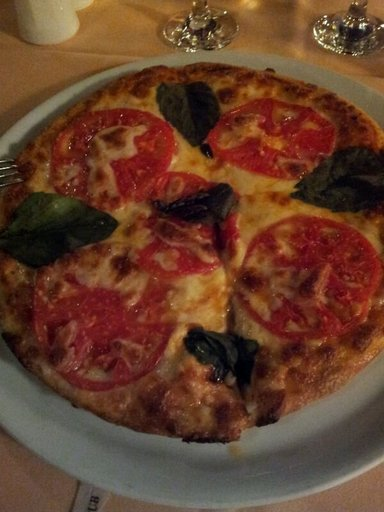

In [7]:
# Get all image paths 
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get Image Class from Path Name (The Image Class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# Load the image using PIL
img = Image.open(random_image_path)

print(f'Random Image Path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

<font size="6" color='pink'>Turning Images into Tensors</font>

<font size="4" color='yellow'>Transforming data with torchvision.transforms</font>

### Image Transformations in PyTorch
The following code applies:
- **Resizing**: Converts all images to 128x128 pixels.
- **Random Flip**: Flips images horizontally with a 50% chance.
- **Tensor Conversion**: Converts images into PyTorch tensors.

In [8]:
print(img.size)

(384, 512)


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((360, 360)),  # Resize images to a consistent size
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images to add variety
    transforms.RandomRotation(degrees=15),  # Small rotation to simulate different angles
    transforms.ColorJitter(brightness=0.2, contrast=1.5, saturation=0.5),  # Boost contrast & colors
    transforms.RandomAffine(degrees=0, shear=10),  # Slight shearing for shape variation
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Enhance textures by blurring edges
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for model stability
])

test_transform = transforms.Compose([
    transforms.Resize((360, 360)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for model stability
])

<font size="6" color='pink'>Turning Images into Dataset</font>

In [10]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [11]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 229
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(360, 360), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.0, 2.5), saturation=(0.5, 1.5), hue=None)
                RandomAffine(degrees=[0.0, 0.0], shear=[-10.0, 10.0])
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(360, 360), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()

In [12]:
# Get class names as List
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

<font size="6" color='pink'>Turn Datasets into DataLoader</font>

# ✅ DataLoader handles batching, shuffling, and parallel processing.

In [15]:
workers = os.cpu_count()
workers

8

In [16]:
torch.manual_seed(42)

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=workers, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=workers, shuffle=False)

In [17]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1dbfb8fd160>,
 <torch.utils.data.dataloader.DataLoader at 0x1dbfb8c11d0>)

In [18]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [19]:
for image_batch, label_batch in train_dataloader:
    print(f'[Batch, CC, Height, Width] ->{image_batch.shape}')
    print(f'Type is {type(image_batch)}')
    break

[Batch, CC, Height, Width] ->torch.Size([32, 3, 360, 360])
Type is <class 'torch.Tensor'>


<font size="4" color='yellow'>Create TinyVGG model class</font>

In [20]:
# class Model(nn.Module):
#     def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
#         super().__init__()
#         self.conv_network1 = nn.Sequential(
#             nn.Conv2d(in_channels=input_shape,
#                      out_channels=hidden_units,
#                      kernel_size=3,
#                      stride=1,
#                      padding=1
#                      ),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=hidden_units,
#                      out_channels=hidden_units,
#                       kernel_size=3,
#                       stride=1,
#                       padding=1
#                      ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)

#         ) 

#         self.conv_network2 = nn.Sequential(
#             nn.Conv2d(in_channels=hidden_units,
#                      out_channels=hidden_units,
#                      kernel_size=3,
#                      stride=1,
#                      padding=1
#                      ),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=hidden_units,
#                      out_channels=hidden_units,
#                      kernel_size=3,
#                      stride=1,
#                      padding=1
#                      ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=hidden_units*32*32,
#                      out_features=output_shape)
#         )      

#     def forward(self, x):
#         print(f"Input Shape: {x.shape}")
#         x = self.conv_network1(x)
#         print(f"After conv_network1: {x.shape}")
#         x = self.conv_network2(x)
#         print(f"After conv_network2: {x.shape}")
#         x = self.classifier(x)
#         print(f"After Classifier: {x.shape}")
#         return x
#         # return self.classifier(self.flatten(self.conv_network2(self.conv_network1(x)))) # This way is preferrable

In [21]:
# torch.manual_seed(42)
# model_1 = Model(
#     input_shape=3,# No. of Color Channels
#     hidden_units=10,
#     output_shape=len(class_names)
# )
# model_1

In [22]:
model_1 = models.efficientnet_b0(pretrained=True)

model_1.classifier = nn.Sequential(
    nn.Linear(model_1.classifier[1].in_features, 256),  # Fully connected layer (FC)
    nn.BatchNorm1d(256),
    nn.ReLU(),  # Activation function
    nn.Dropout(0.4),
    nn.Linear(256, 3)  # Output layer for 3 classes (Pizza, Steak, Sushi)
)

model_1

C:\Users\Dushyant\Downloads\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dushyant\Downloads\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [23]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 360, 360]), torch.Size([32]))

In [24]:
model_1(image_batch)

tensor([[ 0.3308, -0.0821,  0.3160],
        [ 0.1935, -0.4894, -0.0771],
        [-0.2578, -0.2810,  0.1508],
        [-0.1785,  0.2833,  0.1493],
        [ 0.2647,  0.4697,  0.5098],
        [ 0.8927,  0.2920, -0.4332],
        [-0.6051,  0.9625,  0.8406],
        [-0.9917,  0.8975,  0.3231],
        [-0.4262,  0.7987,  0.4979],
        [ 0.3771, -0.0294, -0.4811],
        [ 0.5466, -0.1520,  0.7367],
        [-0.1279,  0.4176,  0.8047],
        [ 0.5231,  0.6835,  0.0881],
        [-0.5219, -0.5964,  0.6268],
        [ 0.3483,  0.3229, -0.1576],
        [-0.6357,  0.9856, -0.1841],
        [ 0.0796, -0.2192, -0.1069],
        [-0.0368, -1.0190,  0.3127],
        [-0.2428, -0.0161,  0.0154],
        [ 0.0420,  0.0639,  0.5421],
        [ 0.7536,  0.6255, -0.4741],
        [ 0.4227,  0.6621,  0.2301],
        [ 0.8164,  0.4046, -0.6375],
        [ 0.1200, -0.6238, -0.0553],
        [-0.0787,  0.4551, -0.2162],
        [ 1.1538,  0.1625,  0.4318],
        [ 0.7733,  0.1614,  0.7051],
 

In [25]:
# Important Parameters
learning_rate = 0.001
epochs = 5

In [26]:
# Loss Function and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

In [27]:
def train_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy):
    train_loss, train_acc = 0,0
    model.train()

    # Add a loop through the training batch
    for batch, (X,y) in enumerate(dataloader):
        # Forward Pass (outputs the raw logits from the model)
        y_pred = model(X)

        # Calcualte Loss and Accuracy per batch
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy(y, y_pred.argmax(dim=1)).item()*100 
        
        # Set Gradients to zero
        optimizer.zero_grad()
        
        # BackPropogation
        loss.backward()

        # Update the Parameters
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [28]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              accuracy):
    test_loss, test_acc = 0,0
    model.eval()

    with torch.inference_mode():
        # Add a loop through the testing batch
        for batch, (X,y) in enumerate(dataloader):
            # Forward Pass (outputs the raw logits from the model)
            test_pred = model(X)
    
            # Calcualte Loss and Accuracy per batch
            loss = loss_function(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy(y, test_pred.argmax(dim=1)).item()*100

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

In [29]:
def train(model: torch.nn.Module,
         train_dataloader:torch.utils.data.DataLoader,
         test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_function: torch.nn.Module,
          accuracy,
          scheduler,
          epochs:int = 5):
   
    # Create empty result dictionary
    results = {'train_loss':[],
              'train_acc':[],
              'test_loss':[],
              'test_acc':[]}
    
    # Loop through training and testing steps for the number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          optimizer=optimizer,
                                          accuracy=accuracy)

        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_function=loss_function,
                                       accuracy=accuracy)
       
        print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f} | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.2f}%")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_loss)  # Pass the validation loss
        else:
            scheduler.step()  # Default step for other schedulers


    return results

In [ ]:
torch.manual_seed(42)

accuracy = Accuracy(task="multiclass", num_classes=len(class_names))

model_1_results = train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_function=loss_function,
                        accuracy=accuracy,
                        scheduler=scheduler,
                       epochs=epochs)

Training Loss: 0.54181 | Training Accuracy: 77.34 | Testing Loss: 0.48062 | Testing Accuracy: 79.55%


In [ ]:
plt.figure(figsize=(15,5))
epochs = range(len(model_1_results['train_loss']))

plt.subplot(1,2,1)
plt.plot(epochs, model_1_results['train_loss'], label='Training Loss')
plt.plot(epochs, model_1_results['test_loss'], label='Testing Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, model_1_results['train_acc'], label='Training Accuracy')
plt.plot(epochs, model_1_results['test_acc'], label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Transfer Learning

In [ ]:
# transfer_model = models.resnet50(pretrained = True)

# for param in transfer_model.parameters():
#     param.requires_grad = False

# transfer_model.fc = nn.Sequential(
#     nn.Linear(transfer_model.fc.in_features, 512),
#     nn.ReLU(),
#     nn.Linear(512, 3)
# )    

In [ ]:
# transfer_model

In [ ]:
# torch.manual_seed(42)

# accuracy = Accuracy(task="multiclass", num_classes=len(class_names))

# transfer_model_results = train(model=transfer_model,
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader,
#                        optimizer=optimizer,
#                        loss_function=loss_function,
#                         accuracy=accuracy,
#                        epochs=epochs)

<font size="6" color='pink'>Uploading Image which is not in data, to test the accuracy of our model</font>

In [ ]:
custom_image_path = data_path/ 'sushi_test1.jpeg'

# if not custom_image_path.is_file():
#     with open(custom_image_path, 'wb') as f:
#         request = requests.get('https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Sushi_platter.jpg/640px-Sushi_platter.jpg')
#         print('Downloading Data')
#         f.write(request.content)
# else:
#     print(f'{custom_image_path} directory already exists, skipping download')

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
                       image_path:str,
                       class_names:List[str] = None,
                       transform=None):
    # Load the Image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixels by value 255 to range them between 0 and 1
    target_image = target_image / 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Turn on eval mode/inference mode to make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension  (this is the batch dimension)
        target_image =target_image.unsqueeze(0)

        # Make Prediction
        target_image_pred = model(target_image)

    # Convert raw logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the Image
    plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange the shape

    if class_names:
        title = f'Prediction: {class_names[target_image_pred_label]} | Probability {target_image_pred_probs.max():.3f}'
    else:
        title = f'Prediction: {target_image_pred_label} | Probability {target_image_pred_probs.max():.3f}'
    plt.title(title)
    plt.axis(False)

In [ ]:
pred_and_plot_image(model=model_1,
                   image_path=custom_image_path,
                   class_names=class_names,
                   transform=custom_image_transform)

In [ ]:
custom_image_path2 = data_path / 'sushi_test2.jpeg'

# # Check if the file already exists
# if not custom_image_path2.is_file():
#     with open(custom_image_path2, 'wb') as f:  # FIX: using custom_image_path2
#         request = requests.get('https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Sushi1.jpg/240px-Sushi1.jpg')
#         print('Downloading Data...')
#         f.write(request.content)
#     print(f'Download complete: {custom_image_path2}')
# else:
#     print(f'{custom_image_path2} already exists, skipping download.')

In [ ]:
pred_and_plot_image(model=model_1,
                   image_path=custom_image_path1,
                   class_names=class_names,
                   transform=custom_image_transform)